*Rodrigo Togneri, 2020-05.*

This notebook illustrates with examples the probability distribution fitting procedure.

In this particular notebook, examples are of stocks financial returns. 

# Import Libraries and Functions

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb # to import relational data from web.
import scipy # Python basic scientific library.
import scipy.stats # SciPy module of statistical functions.
import matplotlib.pyplot as plt

C:\Users\rodto\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Import Stock Data

Here we have chosen to use stock pricing information from WEG, a brazilian industrial company listed in B3 (the brazilian only stock exchange).

In [2]:
WEG = wb.DataReader('WEGE3.SA', data_source='yahoo', start='2010-1-1')

In [3]:
WEG

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,5.547340,5.360950,5.470410,5.423080,1888406.0,3.765263
2010-01-05,5.443790,5.372780,5.423080,5.411240,714532.0,3.757042
2010-01-06,5.464500,5.384620,5.393490,5.440830,2053012.0,3.777586
2010-01-07,5.559170,5.443790,5.485210,5.532540,469820.0,3.841263
2010-01-08,5.739640,5.514790,5.517750,5.733730,1099514.0,3.980949
...,...,...,...,...,...,...
2020-06-08,46.279999,44.259998,44.889999,45.799999,5162800.0,45.799999
2020-06-09,46.080002,43.849998,44.730000,45.810001,4179400.0,45.810001
2020-06-10,46.639999,44.470001,45.930000,44.990002,4847800.0,44.990002


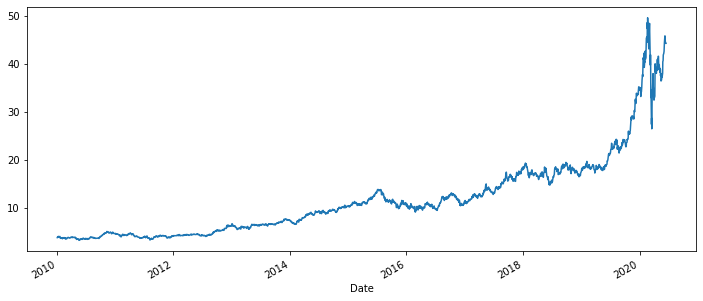

In [4]:
WEG['Adj Close'].plot(figsize=(12, 5))
plt.show()

# Calculate Simple Return

The simple return of a stock in a specific timeframe is the price percentual variation, as illustrates the formula below:

$$
\frac{P_1 - P_0}{P_0} = \frac{P_1}{P_0} - 1
$$

In this example, we calculate the daily basis (our timeframe) return for a period of aproximately 10 years:

In [5]:
WEG['simpleReturn'] = (WEG['Adj Close'] / WEG['Adj Close'].shift(1)) - 1
#print (WEG['simple_return'])

Returns can be plotted as below. Note that accentuated downsize movements are more frequent than upsize ones. This illustrates the famous sentence: "the market goes up stairs, but goes down by elevator".

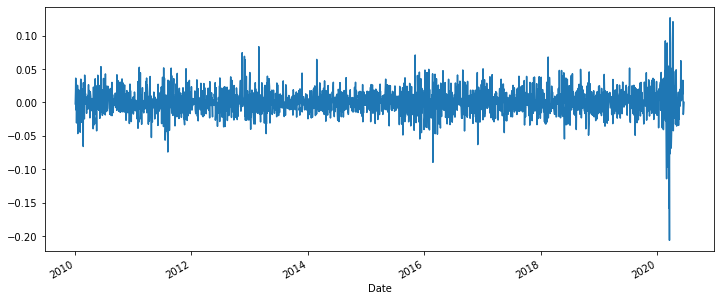

In [6]:
WEG['simpleReturn'].plot(figsize=(12, 5))
plt.show()

Another way to see simple returns data is by plotting the histogram (please be careful you are plotting data from different times, with different contexts, which makes the difference in stock market decisions - this is just a illustrative example). Note that we can also see here that extreme downsize movements are more frequent than upsize ones. This indicates asymmetry. More than that, we can see that extreme events are far away from the main distribution, meaning that this distribution has large tails.

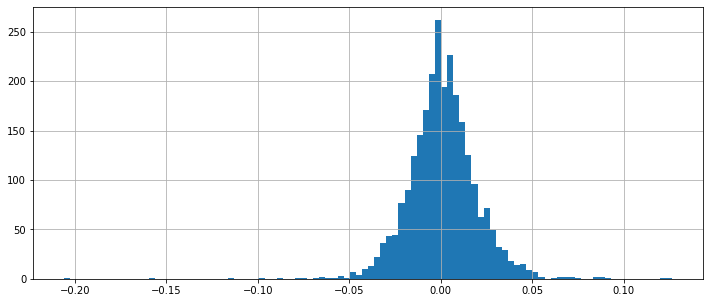

In [7]:
WEG['simpleReturn'].hist(figsize=(12, 5),bins=100)
plt.show()

The daily return mean appears to be tiny, having the first significative digit just in the third position after the point. The good new here is that this stock at least has a positive return mean.

In [8]:
WEG['simpleReturn'].mean()

0.0011433384284692803

But if you calculate the corresponding annual return (considering aprox. 250 working days), you would be surprised with a good 28.59% mean:

In [9]:
print(str(round(WEG['simpleReturn'].mean()*250, 5)*100) + ' %')

28.583 %


# Fit Distribution Model to Data

Our final goal is to find an adjusted theoretical probability distribution model to our data, in order to make it possible to generate random numbers based on them (simulated behaviour). This section is dedicated to find this adjusted theorecical model.

## Is simple return data normal distributed?

Generating WEG simple return array:

In [10]:
WEG_simpleReturn_array = np.array(WEG['simpleReturn'].tolist())
WEG_simpleReturn_array = np.delete(WEG_simpleReturn_array,0)

In [11]:
WEG_simpleReturn_array

array([-0.00218336,  0.00546814,  0.01685636, ..., -0.01790001,
       -0.01644814,  0.00022595])

Generating a fitted normal distribution:

In [12]:
x = scipy.stats.norm.rvs(loc=np.mean(WEG_simpleReturn_array), 
                         scale=np.std(WEG_simpleReturn_array), 
                         size=len(WEG_simpleReturn_array))

In [13]:
x

array([-0.01358767,  0.01041709,  0.00640862, ...,  0.0024793 ,
       -0.00327326, -0.01292857])

And now, let us compare, and discover if simple returns are normal distributed:

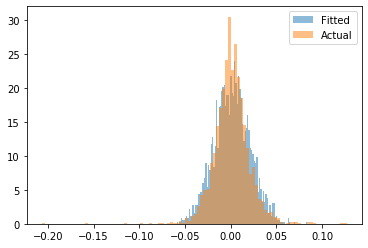

In [14]:
plt.hist(x, alpha=0.5, label='Fitted', bins=100, density=True)
plt.hist(WEG_simpleReturn_array, alpha=0.5, label='Actual', bins=100, density=True)
plt.legend(loc='upper right')

Well, it does not seem that simple returns are normal distributed, because normal distribution is not so concentrated around the mean, and also do not allow so many extreme values, as compared to the actual distribution.

## Let's try to find a better suited distribution.

SciPy has a lot of distribution models to be tested: https://docs.scipy.org/doc/scipy/reference/stats.html.

Here we will create a class to fitted distributions, and will test them using Kolmogorov-Smirnov test (there are other goodness-of-fit measures and tests: AIC - Akaike Information Criteria, BIC - Bayesian Information Criteria, Cramer-VonMises test, Anderson-Darling test, Shapiro-Wilk test, Hosmer-Lemeshow test, QQ-plot, PP-plot etc).

In [15]:
class fittedDistribution(object):
    
    def __init__(self,dist_names_list = []):
        
        self.dist_names = ["beta","gamma","laplace","lognorm","norm","t"]
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            
            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))
        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p
        
        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the Fit method.')
            
    def Plot(self,y):
        x = self.Random(n=len(y))
        plt.hist(x, alpha=0.5, label='Fitted', bins=100, density=True)
        plt.hist(y, alpha=0.5, label='Actual', bins=100, density=True)
        plt.legend(loc='upper right')

Creating an instance and fitting a theoretical distribution to WEG simple return data:

In [16]:
dst = fittedDistribution()
dst.Fit(WEG_simpleReturn_array)

C:\Users\rodto\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\rodto\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


('t', 0.4319115500991877)

It founded that Student t is a better distribution. See how Student t is much more  fit to data:

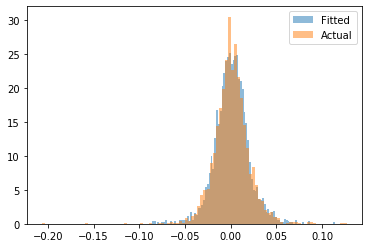

In [17]:
dst.Plot(WEG_simpleReturn_array)

See how Student t distribution is better than normal and others distributions (higher p-value):

In [18]:
dst.dist_results

[('beta', 4.018382546597209e-07),
 ('gamma', 2.2983052370658144e-12),
 ('laplace', 0.0014510350462133836),
 ('lognorm', 1.4625901472797118e-06),
 ('norm', 1.1651207610232656e-06),
 ('t', 0.4319115500991877)]

# Simulate Values Based on Fitted Distribution

In [20]:
dst.params[dst.DistributionName]

(4.596139745680032, 0.0009451032293363365, 0.014332396503355053)

In [21]:
z = scipy.stats.t.rvs(dst.params[dst.DistributionName][0],
                      dst.params[dst.DistributionName][1],
                      dst.params[dst.DistributionName][2],
                      size=len(WEG_simpleReturn_array))

In [22]:
z

array([ 0.01928829, -0.00266256,  0.02536989, ..., -0.01266439,
        0.0147085 , -0.00230057])

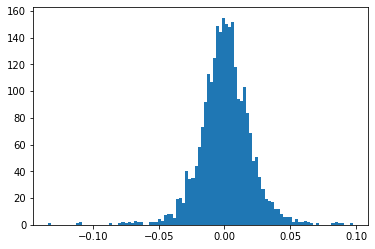

In [23]:
plt.hist(z, bins=100)
plt.show()